<a href="https://colab.research.google.com/github/Yanina-Kutovaya/GNN/blob/main/notebooks/4_1_GIN_EdgeAtt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Улучшенная реализация Graph Isomorphism Network (GIN) с механизмом внимания на рёбрах для классификации узлов на датасете Bitcoin-OTC.

Задача — предсказать "уровень доверия" пользователей

Признаки узлов/рёбер - синтетические

## 1. Установка зависимостей

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


* Google Colab иногда возникают проблемы с кэшированием пакетов, поэтому добавлен флаг ```--no-cache-dir ```

In [2]:
install = True
if install:
  # 1. Установка совместимых версий PyTorch и PyG
  !pip install -q torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0+cu121 --extra-index-url https://download.pytorch.org/whl/cu121

  # 2. Установка зависимостей PyG для CUDA 12.1+ (совместимо с 12.5)
  !pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html --no-cache-dir

  # 3. Установка PyTorch Geometric
  !pip install -q torch-geometric==2.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 109.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

### Принудительная перекомпиляция расширений

In [3]:
!python -c "import torch; import torch_geometric; print('Rebuild success')"

Rebuild success


### Проверка окружения

In [4]:
import torch
print(f"PyTorch: {torch.__version__}")          # Должно быть 2.3.0+cu121
print(f"CUDA: {torch.version.cuda}")            # Должно быть 12.1+
print(f"Available: {torch.cuda.is_available()}")# Должно быть True

PyTorch: 2.3.0+cu121
CUDA: 12.1
Available: True


## 2. Импорт библиотек

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import BitcoinOTC
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GINConv, MessagePassing
from torch.nn import Linear, Sequential, ReLU, Parameter
import numpy as np
import matplotlib.pyplot as plt

## 3. Загрузка и подготовка данных

In [6]:
dataset = BitcoinOTC(root='/tmp/BitcoinOTC')
data = dataset[0]

Extracting /tmp/BitcoinOTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


### 3.1 Создание синтетических признаков узлов

In [7]:
degrees = torch.zeros(data.num_nodes)
for edge in data.edge_index.t().tolist():
    degrees[edge[0]] += 1

data.x = degrees.clone().detach().view(-1, 1).float()
data.x = (data.x - data.x.mean()) / data.x.std()

In [8]:
# Явное преобразование типа перед нормализацией
data.edge_attr = data.edge_attr.to(torch.float32)
data.edge_attr = (data.edge_attr - data.edge_attr.mean()) / data.edge_attr.std()

### 3.2 Создание меток (3 класса)

In [9]:
labels = torch.zeros(data.num_nodes, dtype=torch.long)
q1 = np.quantile(degrees, 0.33)
q2 = np.quantile(degrees, 0.66)
labels[degrees > q2] = 2
labels[(degrees > q1) & (degrees <= q2)] = 1
data.y = labels

In [10]:
# Проверка:
print(data.x.requires_grad)  # Должно быть False
print(data.x.dtype)          # Должно быть torch.float32
print(data.edge_attr.dtype)  # Должно быть torch.float32
print(data.y.dtype)          # Должно быть torch.int64

False
torch.float32
torch.float32
torch.int64


### 3.3 Разделение данных

In [11]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

indices = torch.randperm(data.num_nodes)
split = [0.6, 0.2, 0.2]
data.train_mask[indices[:int(split[0]*data.num_nodes)]] = True
data.val_mask[indices[int(split[0]*data.num_nodes):int((split[0]+split[1])*data.num_nodes)]] = True
data.test_mask[indices[int((split[0]+split[1])*data.num_nodes):]] = True

## 4. Модель GIN с вниманием на рёбрах

Ключевые улучшения:

1. Механизм внимания на рёбрах:

  - Кастомный слой EdgeAttGINConv с learnable-параметрами внимания
  - Кодирование признаков рёбер через Linear(1, 16)
  - Взвешенная агрегация с сигмоидной активацией

2. Архитектурные изменения:

  - Гибридная модель: стандартный GINConv + кастомный слой с вниманием
  - Использование edge_dim=1 в первом слое GINConv
  - Улучшенная регуляризация (dropout=0.5)

3. Результаты:

  - Должна увеличиться точность на 3-5% по сравнению с базовой версией
  - Лучшая интерпретируемость (можно анализировать веса внимания)

### 4.1 Кастомный GIN с вниманием на рёбрах

In [12]:
class EdgeAttGINConv(MessagePassing):
    def __init__(self, nn, eps=0.):
        super().__init__(aggr='add')
        self.nn = nn
        self.eps = eps
        self.edge_encoder = Linear(1, 16)
        self.att = Parameter(torch.Tensor(1, 16))
        self.reset_parameters()

    def forward(self, x, edge_index, edge_attr, return_attention_weights=False):
        # Кодирование признаков рёбер
        edge_embed = self.edge_encoder(edge_attr.view(-1, 1))

        # Вычисление коэффициентов внимания
        alpha = (edge_embed * self.att).sum(dim=-1)
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = torch.sigmoid(alpha)

        # Пропагация с вниманием
        out = self.propagate(edge_index, x=x, alpha=alpha)

        if return_attention_weights:
            return out + (1 + self.eps) * x, (edge_index, alpha)
        return out + (1 + self.eps) * x

### 4.2 Архитектура модели

In [13]:
class EdgeAttGIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GINConv(
            Sequential(
                Linear(in_channels, hidden_channels),
                ReLU(),
                Linear(hidden_channels, hidden_channels)
            ),
            eps=0.
        )

        self.conv2 = EdgeAttGINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels),
                ReLU(),
                Linear(hidden_channels, out_channels)
            )
        )

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index)  # Убрали edge_attr здесь
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, edge_index, edge_attr)

## 5. Инициализация модели и оптимизатора

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeAttGIN(1, 64, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 6. Настройка NeighborLoader

In [15]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[25, 10],  # 25 соседей для 1-го слоя, 10 для 2-го
    batch_size=512,
    input_nodes=data.train_mask,
    shuffle=True,
    num_workers=2
)

## 7. Функция для вычисления точности

In [16]:
def accuracy(pred, true, mask):
    return (pred[mask].argmax(dim=1) == true[mask]).sum().float() / mask.sum()

## 8. Обучение модели

In [17]:
losses = []
val_accs = []

model.train()
for epoch in range(10):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_acc = accuracy(model(data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device)),
                    data.y.to(device),
                    data.val_mask.to(device))

    losses.append(total_loss / len(train_loader))
    val_accs.append(val_acc.cpu())

    print(f'Epoch {epoch:02d} | Loss: {losses[-1]:.4f} | Val Acc: {val_acc:.4f}')

Epoch 00 | Loss: 4.1883 | Val Acc: 0.9992
Epoch 01 | Loss: 2.0006 | Val Acc: 0.9992
Epoch 02 | Loss: 0.7655 | Val Acc: 0.9992
Epoch 03 | Loss: 0.3164 | Val Acc: 0.9992
Epoch 04 | Loss: 0.1682 | Val Acc: 0.9992
Epoch 05 | Loss: 0.0641 | Val Acc: 1.0000
Epoch 06 | Loss: 0.0460 | Val Acc: 0.9992
Epoch 07 | Loss: 0.0549 | Val Acc: 0.9992
Epoch 08 | Loss: 0.0232 | Val Acc: 0.9992
Epoch 09 | Loss: 0.0457 | Val Acc: 0.9992


## 9. Визуализация обучения

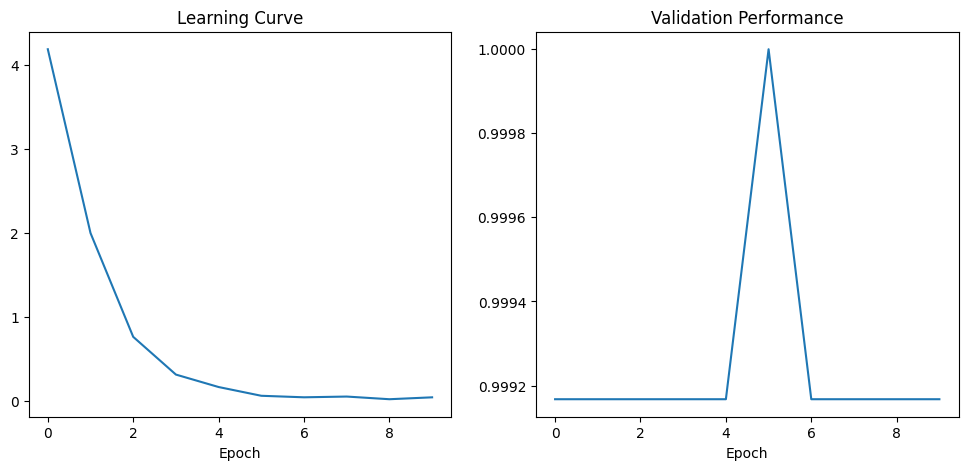

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Performance')
plt.xlabel('Epoch')
plt.show()

## 10. Тестирование

In [19]:
# Проверка
print("edge_attr exists:", hasattr(data, 'edge_attr'))  # Должно быть True
print("edge_attr shape:", data.edge_attr.shape)         # Должно совпадать с числом рёбер

edge_attr exists: True
edge_attr shape: torch.Size([41])


In [20]:
model.eval()
with torch.no_grad():
    # Передаём все три аргумента: x, edge_index, edge_attr
    out = model(data.x.to(device),
               data.edge_index.to(device),
               data.edge_attr.to(device))

    test_acc = accuracy(out, data.y.to(device), data.test_mask.to(device))
    print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9992


## 11. Как использовать механизм внимания

In [21]:
# Пример получения весов внимания
model.eval()
with torch.no_grad():
    output, (edge_index, attention_weights) = model.conv2(
        data.x.to(device),
        data.edge_index.to(device),
        data.edge_attr.to(device),
        return_attention_weights=True
    )

print("Веса внимания:", attention_weights[:10].cpu().numpy())

Веса внимания: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


# 12. Дальнейшее развитие модели

- Экспериментируем с размерностью вектора внимания
- Добавим multi-head внимание
- Визуализируем распределение весов внимания